<h1>**Bagging ensemble methods on German Credit Risk data set**</h1>

# Tables of Content:

**1. [Introduction](#intro_bag)** <br>
    - Information about the data set <br>
**2. [Reason for using this model](#reasons_bag)** <br>
    - The purpose of this specific model <br>
**3. [Libraries](#libraries_bag)** <br>
    - Importing Libraries <br>
    - Importing Dataset <br>
**4. [Preprocess](#preprocessing_bag)** <br>
    - 4.1 Separating feature and target variables <br>
    - 4.2 [Feature Selection](#feature_selection_bag)<br>
    - 4.3 [Spliting the X and Y in train and test](#split_bag)<br>
**5. [Models](#modelling_bag)**<br>
    - 5.1 Random Forest<br>
    - 5.2 Extra Trees<br>
    - 5.3 [Comparison between the models](#comp_bag)<br>
    - 5.4 [Setting the optimum no. of trees](#opt_bag)<br>
    - 5.5 [Metrics](#metrics_bag)<br>
    - 5.6 [Confusion Matrix and Classification Report](#conmat_bag)<br>
    - 5.7 ROC curve and Precision Recall curve<br>
    - 5.8 Assessing feature importances
**6. [Conclusion and Benefits of the model](#summary_bag)** <br>
    The summary of the model implementation

<a id="intro_bag"></a> <br>
# **1. Introduction:** 
<h2>Context</h2>
The original dataset contains 1000 entries with 9 feature variables. In this dataset, each entry represents a person who takes a credit by a bank. Each person is classified as good or bad credit risks according to the set of attributes.

<h2>Content</h2>
I have cleaned and preprocessed the data already and also I have created a more relevant feature from two of the most important feature in the data set i.e. Credit amount and Duration. The preprocessed data set is already saved in a CSV file and we are going to use that file for our model training and testing purposes. The selected variables from the orginal data set are:

<b>Age </b>(numeric)<br>
<b>Sex </b>(text: male, female)<br>
<b>Job </b>(numeric: 0 - unskilled and non-resident, 1 - unskilled and resident, 2 - skilled, 3 - highly skilled)<br>
<b>Housing</b> (text: own, rent, or free)<br>
<b>Saving accounts</b> (text - little, moderate, quite rich, rich)<br>
<b>Checking account </b>(numeric, in DM - Deutsch Mark)<br>
<b>Credit amount</b> (numeric, in DM)<br>
<b>Duration</b> (numeric, in month)<br>
<b>Purpose</b>(text: car, furniture/equipment, radio/TV, domestic appliances, repairs, education, business, vacation/others<br>
<b>Risk </b> (Value target - Good or Bad Risk)<br>

<a id="resons_bag"></a> <br>
# **2. Reason for using this model**
<h2>Our goal is to: </h2>

- Estimate the appropriate amount of trees required for our classification task, which will be achieved by plotting out-of-bag sample error versus the number of trees.
- We are going to compare between the two models with the help of plotting out-of-bag error vs number of trees.
- Moreover, we will evaluate these models using metrics such as F1-score, Precision, Recall, Accuracy, Confusion_matrix, and Area-under-curve (AUC).
- We would mostly focus on reducing the False Positive Rate (FPR) as classifying bad as good is severe than classifying good as bad, because lending to a person who is going to default will incur losses to the organization.
- We will plot the ROC curve (TPR vs. FPR) and Precision-Recall curve for the more accurate model.
- In the end, we will visualize features in descending order of relative importance.

<a id="libraries_bag"></a> <br>
# **3. Libraries**

### Imports

In [2]:
import numpy as np
from numpy import mean
from numpy import std
import pandas as pd

from scipy import stats 
import math

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline

from colorsetup import colors, palette

### Read the data

In [3]:
gcr_data = pd.read_csv("gcr_data_imputed2.csv")
#gcr_data = pd.read_csv("gcr_processed.csv")

<a id="preprocessing_bag"></a> <br>
# **4. Preprocess**

<h2>4.1 Separating feature and target</h2>

In [4]:
#X = gcr_data.drop(['Risk','Credit_amount/duration'], axis=1)
#X = gcr_data.drop(['Risk', 'Credit_amount', 'Duration'], axis=1)
X = gcr_data.drop(['Risk'], axis=1)

y = gcr_data['Risk']

<a id="feature_selection_bag"></a>
<h2>4.2 Feature Selection</h2>

### 1. Univariate Selection

In [5]:
#apply SelectKBest class to extract top 5 best features
bestfeatures = SelectKBest(score_func=chi2, k=6)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns, dfscores], axis=1)
featureScores.columns = ['Specs', 'Score']  #naming the dataframe columns
print(featureScores.nlargest(10, 'Score'))  #print best features

                         Specs      Score
12     Checking account_little  33.595555
8       Saving accounts_little  10.291479
13   Checking account_moderate   7.248111
20            Purpose_radio/TV   5.707578
7                 Housing_rent   4.901023
11        Saving accounts_rich   4.853800
4                     Duration   4.699713
5                 Housing_free   4.113929
6                  Housing_own   3.604819
10  Saving accounts_quite rich   3.270982


In [6]:
#X = gcr_data[featureScores.nlargest(23, 'Score')['Specs'].values]

### 2. Feature Importance

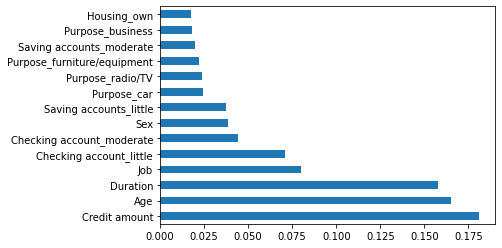

In [7]:
from sklearn.ensemble import ExtraTreesClassifier

model_fi = ExtraTreesClassifier()
model_fi.fit(X,y)
#print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers

#plot graph of feature importances for better visualization
feat_importances = pd.Series(model_fi.feature_importances_, index=X.columns)
feat_importances.sort_values(ascending=True).nlargest(14).plot(kind='barh')
plt.show()

In [8]:
# evaluate a give model using cross-validation
def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    return scores

results = list()
for i in range(1,24):
        scores = evaluate_model(model_fi, X[feat_importances.nlargest(i).index], y)
        results.append(scores)
        print('> %s) %.3f (%.3f)' % (i, mean(scores), std(scores)))

> 1) 0.597 (0.035)
> 2) 0.609 (0.038)
> 3) 0.662 (0.044)
> 4) 0.670 (0.044)
> 5) 0.725 (0.037)
> 6) 0.720 (0.033)
> 7) 0.721 (0.038)
> 8) 0.733 (0.035)
> 9) 0.722 (0.028)
> 10) 0.717 (0.029)
> 11) 0.718 (0.033)
> 12) 0.725 (0.027)
> 13) 0.726 (0.029)
> 14) 0.712 (0.027)
> 15) 0.711 (0.021)
> 16) 0.714 (0.023)
> 17) 0.714 (0.031)
> 18) 0.709 (0.030)
> 19) 0.704 (0.030)
> 20) 0.705 (0.024)
> 21) 0.711 (0.031)
> 22) 0.708 (0.026)
> 23) 0.709 (0.026)


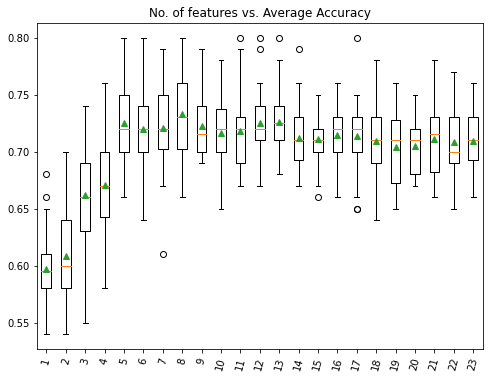

In [9]:
no_of_features = [str(i) for i in range(1,24)]
# plot model performance for comparison
plt.figure(figsize=(8,6))
plt.boxplot(results, labels=no_of_features, showmeans=True)
plt.xticks(rotation=75)
plt.title('No. of features vs. Average Accuracy')
plt.show()

### 3. Correlation Matrix with Heatmap

### 4. RFE

In [10]:
# get a list of models to evaluate
def get_models():
    models = dict()
    # lr
    rfe = RFE(estimator=LogisticRegression(), n_features_to_select=5)
    model = RandomForestClassifier()
    models['lr'] = Pipeline(steps=[('s',rfe),('m',model)])
    # perceptron
    rfe = RFE(estimator=Perceptron(), n_features_to_select=5)
    model = RandomForestClassifier()
    models['per'] = Pipeline(steps=[('s',rfe),('m',model)])
    # cart
    rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=5)
    model = RandomForestClassifier()
    models['cart'] = Pipeline(steps=[('s',rfe),('m',model)])
    # rf
    rfe = RFE(estimator=RandomForestClassifier(), n_features_to_select=5)
    model = RandomForestClassifier()
    models['rf'] = Pipeline(steps=[('s',rfe),('m',model)])
    # gbm
    rfe = RFE(estimator=GradientBoostingClassifier(), n_features_to_select=5)
    model = RandomForestClassifier()
    models['gbm'] = Pipeline(steps=[('s',rfe),('m',model)])
    return models
 
# evaluate a give model using cross-validation
def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
    return scores

In [11]:
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X, y)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))

>lr 0.711 (0.046)
>per 0.678 (0.041)
>cart 0.720 (0.044)
>rf 0.721 (0.039)
>gbm 0.722 (0.040)


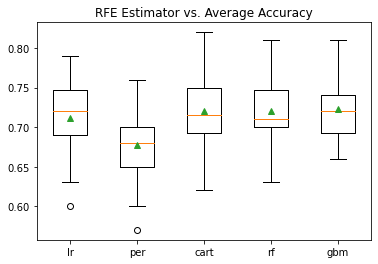

In [12]:
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.title('RFE Estimator vs. Average Accuracy')
plt.show()

In [13]:
# get a list of models to evaluate
def get_models():
    models = dict()
    for i in range(2, 24):
        rfe = RFE(estimator=GradientBoostingClassifier(), n_features_to_select=i)
        model = RandomForestClassifier()
        models[str(i)] = Pipeline(steps=[('s',rfe),('m',model)])
    return models

# evaluate a give model using cross-validation
def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    return scores

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X, y)
    results.append(scores)
    names.append(name)
    print('> %s) %.3f (%.3f)' % (name, mean(scores), std(scores)))

> 2) 0.613 (0.032)
> 3) 0.649 (0.040)
> 4) 0.715 (0.042)
> 5) 0.733 (0.035)
> 6) 0.726 (0.031)
> 7) 0.740 (0.033)
> 8) 0.738 (0.029)
> 9) 0.741 (0.033)
> 10) 0.739 (0.035)
> 11) 0.742 (0.034)
> 12) 0.734 (0.038)
> 13) 0.729 (0.037)
> 14) 0.730 (0.029)
> 15) 0.739 (0.036)
> 16) 0.741 (0.035)
> 17) 0.742 (0.029)
> 18) 0.735 (0.036)
> 19) 0.738 (0.034)
> 20) 0.740 (0.031)
> 21) 0.731 (0.038)
> 22) 0.736 (0.038)
> 23) 0.733 (0.035)


In [14]:
# define RFE
rfe = RFE(estimator=GradientBoostingClassifier(), n_features_to_select=17)
# fit RFE
rfe.fit(X, y)
# summarize all features
for i in range(X.shape[1]):
    print('Column: %d, Selected %s, Rank: %.3f' % (i, rfe.support_[i], rfe.ranking_[i]))

Column: 0, Selected True, Rank: 1.000
Column: 1, Selected True, Rank: 1.000
Column: 2, Selected True, Rank: 1.000
Column: 3, Selected True, Rank: 1.000
Column: 4, Selected True, Rank: 1.000
Column: 5, Selected False, Rank: 2.000
Column: 6, Selected True, Rank: 1.000
Column: 7, Selected True, Rank: 1.000
Column: 8, Selected True, Rank: 1.000
Column: 9, Selected True, Rank: 1.000
Column: 10, Selected False, Rank: 7.000
Column: 11, Selected False, Rank: 3.000
Column: 12, Selected True, Rank: 1.000
Column: 13, Selected True, Rank: 1.000
Column: 14, Selected True, Rank: 1.000
Column: 15, Selected True, Rank: 1.000
Column: 16, Selected True, Rank: 1.000
Column: 17, Selected False, Rank: 6.000
Column: 18, Selected True, Rank: 1.000
Column: 19, Selected True, Rank: 1.000
Column: 20, Selected True, Rank: 1.000
Column: 21, Selected False, Rank: 4.000
Column: 22, Selected False, Rank: 5.000


<a id="split_bag"></a>
<h2>4.3 StratifiedShuffleSplit</h2>

In [15]:
#X = gcr_data[feat_importances.nlargest(13).index]
X = gcr_data[X.columns[rfe.support_]]

#X.head()

In [16]:
from sklearn.model_selection import StratifiedShuffleSplit

strat_shuf_split = StratifiedShuffleSplit(n_splits=1, 
                                          test_size=0.3, 
                                          random_state=42)

train_idx, test_idx = next(strat_shuf_split.split(X, gcr_data.Risk))

# Create the dataframes
X_train = X.loc[train_idx, X.columns]
y_train = gcr_data.loc[train_idx, 'Risk']

X_test  = X.loc[test_idx, X.columns]
y_test  = gcr_data.loc[test_idx, 'Risk']

In [17]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((700, 17), (700,), (300, 17), (300,))

<a id="modelling_bag"></a> <br>
# **5. Models**

#### Suppressing any warnings

In [18]:
# Suppress warnings about too few trees from the early models
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

<h2>5.1 Random Forest Classifier</h2>

The RandomForestClassifier is trained using bootstrap aggregation, where each new tree is fit from a bootstrap sample of the training observations z=(xi,yi). The out-of-bag (OOB) error is the average error for each zi calculated using predictions from the trees that do not contain zi in their respective bootstrap sample. This allows the RandomForestClassifier to be fit and validated whilst being trained.

In [19]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the random forest estimator
# Note that the number of trees is not setup here

# oob_score > Whether to use out-of-bag samples to estimate the generalization accuracy.
# warm_start > When set to True, reuse the solution of the previous call to fit and add more estimators to the ensemble, otherwise, just fit a whole new forest.
# n_jobs > The number of jobs to run in parallel. fit, predict, decision_path and apply are all parallelized over the trees. None means 1 unless in a joblib.parallel_backend context. -1 means using all processors. 

RF = RandomForestClassifier(oob_score=True,
                            random_state=42, 
                            warm_start=True,
                            n_jobs=-1)

oob_list = list()

# Iterate through all of the possibilities for 
# number of trees
for n_trees in [15, 20, 30, 40, 50, 100, 150, 200, 300, 400]:
    
    # Use this to set the number of trees
    RF.set_params(n_estimators=n_trees)

    # Fit the model
    RF.fit(X_train, y_train)

    # Get the oob error
    oob_error = 1 - RF.oob_score_
    
    # Store it
    oob_list.append(pd.Series({'n_trees': n_trees, 'oob': oob_error}))

rf_oob_df = pd.concat(oob_list, axis=1).T.set_index('n_trees')

#rf_oob_df

<h2>5.2 Extra Trees Classifier</h2>

In [20]:
from sklearn.ensemble import ExtraTreesClassifier

# Initialize the random forest estimator
# Note that the number of trees is not setup here

# bootstrap > Whether bootstrap samples are used when building trees. If False, the whole dataset is used to build each tree.

EF = ExtraTreesClassifier(oob_score=True, 
                          random_state=42, 
                          warm_start=True,
                          bootstrap=True,
                          n_jobs=-1)

oob_list = list()

# Iterate through all of the possibilities for 
# number of trees
for n_trees in [15, 20, 30, 40, 50, 100, 150, 200, 300, 400]:
    
    # Use this to set the number of trees
    EF.set_params(n_estimators=n_trees)
    EF.fit(X_train, y_train)

    # oob error
    oob_error = 1 - EF.oob_score_
    oob_list.append(pd.Series({'n_trees': n_trees, 'oob': oob_error}))

et_oob_df = pd.concat(oob_list, axis=1).T.set_index('n_trees')

#et_oob_df

<a id="comp_bag"></a>
<h2>5.3 Comparison between the models</h2>

In [21]:
oob_df = pd.concat([rf_oob_df.rename(columns={'oob':'RandomForest'}),
                    et_oob_df.rename(columns={'oob':'ExtraTrees'})], axis=1)

#oob_df

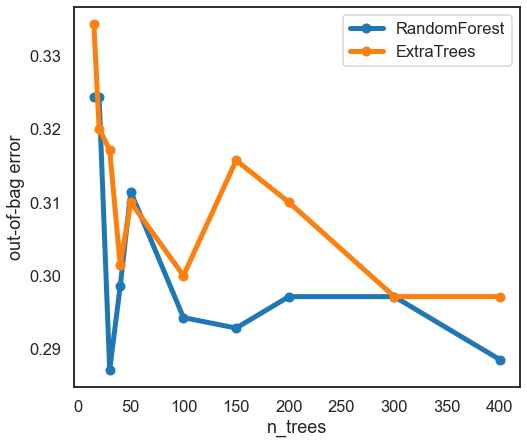

In [22]:
sns.set_context('talk')
sns.set_style('white')

ax = oob_df.plot(marker='o', figsize=(8, 7), linewidth=5)
ax.set(ylabel='out-of-bag error');

<a id="opt_bag"></a>
<h2>5.4 Setting the optimum no. of trees</h2>

In [23]:
RF_opt = RF.set_params(n_estimators=400)
ET_opt = EF.set_params(n_estimators=400)

<a id="metrics_bag"></a>
<h2>5.5 Metrics</h2>

In [24]:
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.preprocessing import label_binarize

y_pred = list()
y_prob = list()

labels = ['rf', 'et']
models = [RF_opt, ET_opt]

for lab,mod in zip(labels, models):
    y_pred.append(pd.Series(mod.predict(X_test), name=lab))
    y_prob.append(pd.Series(mod.predict_proba(X_test).max(axis=1), name=lab))
    
y_pred = pd.concat(y_pred, axis=1)
y_prob = pd.concat(y_prob, axis=1)

# y_pred.head()
# y_prob.head()

metrics = list()
cm = dict()

for lab in labels:

    # Precision, recall, f-score from the multi-class support function
    precision, recall, fscore, _ = score(y_test, y_pred[lab], average='weighted')
    
    # The usual way to calculate accuracy
    accuracy = accuracy_score(y_test, y_pred[lab])
    
    # ROC-AUC scores can be calculated by binarizing the data
    auc = roc_auc_score(label_binarize(y_test, classes=[0,1]),
              label_binarize(y_pred[lab], classes=[0,1]), 
              average='weighted')
    
    # Last, the confusion matrix
    cm[lab] = confusion_matrix(y_test, y_pred[lab])
    
    metrics.append(pd.Series({'precision':precision, 'recall':recall, 
                              'fscore':fscore, 'accuracy':accuracy,
                              'auc':auc}, 
                             name=lab))

metrics = pd.concat(metrics, axis=1)

metrics

,rf,et
precision,0.722500,0.713926
recall,0.740000,0.730000
fscore,0.722667,0.717232
accuracy,0.740000,0.730000
auc,0.642857,0.642063


<a id="conmat_bag"></a>
<h2>5.6 Confusion Matrix and Classification Report</h2>

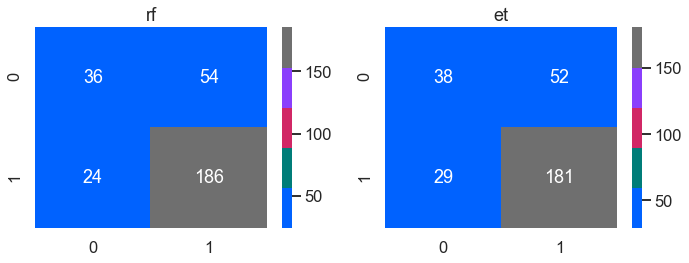

In [25]:
sns.set_context('talk')

fig, axList = plt.subplots(nrows=1, ncols=2)
axList = axList.flatten()
fig.set_size_inches(10, 4)


for ax,lab in zip(axList, labels):
    sns.heatmap(cm[lab], ax=ax, annot=True, fmt='d', cmap=colors);
    ax.set(title=lab);
    
plt.tight_layout()

In [26]:
from sklearn.metrics import classification_report, f1_score

print('#'*60)

y_pred_rf = RF_opt.predict(X_test)
# Preciision, recall, f-score from the multi-class support function
print('Random Forest')
print(classification_report(y_test, y_pred_rf))
print('Accuracy score: ', round(accuracy_score(y_test, y_pred_rf), 3))
print('F1 Score: ', round(f1_score(y_test, y_pred_rf), 3))

print('\n')
print('#'*60)

y_pred_et = ET_opt.predict(X_test)
# Preciision, recall, f-score from the multi-class support function
print('Extra Trees')
print(classification_report(y_test, y_pred_et))
print('Accuracy score: ', round(accuracy_score(y_test, y_pred_et), 3))
print('F1 Score: ', round(f1_score(y_test, y_pred_et), 3))

############################################################
Random Forest
              precision    recall  f1-score   support

           0       0.60      0.40      0.48        90
           1       0.78      0.89      0.83       210

    accuracy                           0.74       300
   macro avg       0.69      0.64      0.65       300
weighted avg       0.72      0.74      0.72       300

Accuracy score:  0.74
F1 Score:  0.827


############################################################
Extra Trees
              precision    recall  f1-score   support

           0       0.57      0.42      0.48        90
           1       0.78      0.86      0.82       210

    accuracy                           0.73       300
   macro avg       0.67      0.64      0.65       300
weighted avg       0.71      0.73      0.72       300

Accuracy score:  0.73
F1 Score:  0.817


<h2>5.7 ROC curve and Precision-Recall curve</h2>

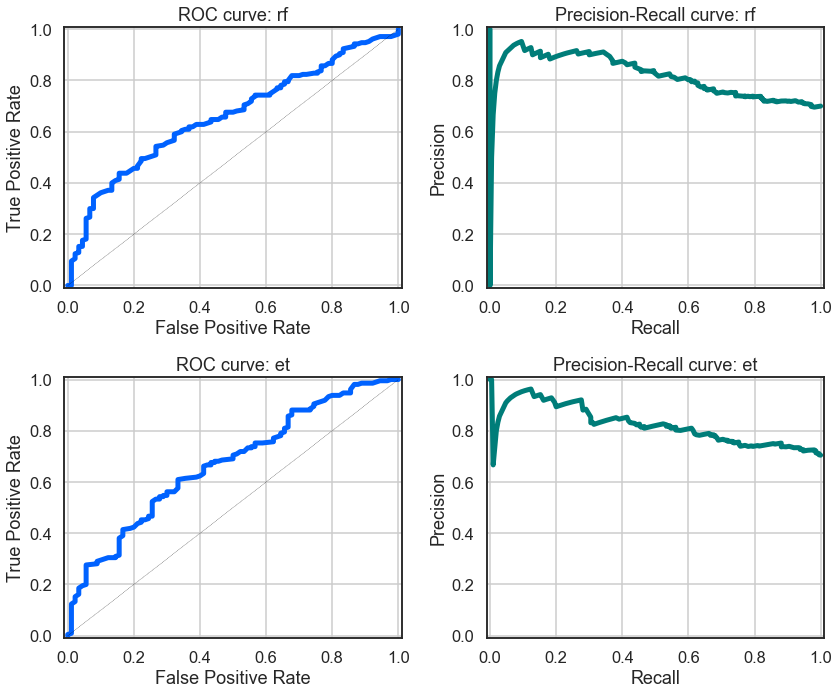

In [27]:
from sklearn.metrics import roc_curve, precision_recall_curve, confusion_matrix

sns.set_context('talk')

fig, axList = plt.subplots(nrows=2, ncols=2)
fig.set_size_inches(12, 10)

for i, lab in zip(range(2),labels):

    # Plot the ROC-AUC curve

    ax = axList[i][0]
    fpr, tpr, thresholds = roc_curve(y_test, y_prob[lab])
    ax.plot(fpr, tpr, color=colors[0], linewidth=5)

    # It is customary to draw a diagonal dotted line in ROC plots.
    # This is to indicate completely random prediction. Deviation from this
    # dotted line towards the upper left corner signifies the power of the model.
    ax.plot([0, 1], [0, 1], ls='--', color='black', lw=.3)
    ax.set(xlabel='False Positive Rate',
           ylabel='True Positive Rate',
           xlim=[-.01, 1.01], ylim=[-.01, 1.01],
           title='ROC curve: {}'.format(lab))
    ax.grid(True)

    # Plot the precision-recall curve

    ax = axList[i][1]
    precision, recall, _ = precision_recall_curve(y_test, y_prob[lab])
    ax.plot(recall, precision, color=colors[1], linewidth=5)
    ax.set(xlabel='Recall', ylabel='Precision',
           xlim=[-.01, 1.01], ylim=[-.01, 1.01],
           title='Precision-Recall curve: {}'.format(lab))
    ax.grid(True)

plt.tight_layout()

<h2>5.8 Assessing Feature Importances</h2>

<a id="summary_bag"></a> <br>
# **6. Conclusion and Benefits of the model**

- The benefit of using ensemble methods is that they give results very fast and mostly gives good accuracy on both classes in binary classification.
- We are getting almost same accuracy for both the 'Good' and the 'Bad' class i.e. about 76%.
- For the given dataset, we are getting the minimum out-of-bag (OOB) error at 'n_estimators=100' when modelled using RandomForestClassifier.
- The ExtraTreesClassifier has comparatively more OOB error than RandomForestClassifier.
- All the metrics such as accuracy, precision, recall, auc and fscore for both the models are quite similar.
- The FPR for RandomForestClassifier is 34.04% and for the ExtraTreesClassifier it is 33.33% which does not reflect much difference.
- The relative assessment of feature importances revealed almost similar behavior, however there are slight differences in the relative importance value for each feature for the two models. 
- Instead of Polynomial feature (Credit_amount/duration), orginal columns resulted in better metrics.

########################################################################################################################################